# Running Pastas with a synthetic ModFlow model

The purpose of this notebook is demonstrate a Pastas model on a synthetic groundwater case created using ModFlow. A simple ModFlow groundwater model is created. A groundwater head series is simulated using the groundwater model. Time series analysis is performed on this series using Pastas.

The ModFlow software is run using the flopy python package. In order to run this notebook flopy and ModFlow need to be installed.

Flopy can be installed with pip using the following command in the command prompt:

```pip install flopy```

[Link to flopy github](https://modflowpy.github.io/flopydoc/ )

This example notebook uses ModFlow version 2005. The executable and further documentation on ModFlow can be found at:

[Link to ModFlow](https://www.usgs.gov/mission-areas/water-resources/science/modflow-and-related-programs?qt-science_center_objects=0#qt-science_center_objects)

The first step of the example notebook is to import the required packages. 

In [1]:
import flopy
import flopy.modflow as mf
import numpy as np
import matplotlib.pyplot as plt
import pastas as ps
import pandas as pd
import flopy.plot as fp
%matplotlib inline

flopy is installed in C:\Anaconda3\lib\site-packages\flopy


### Importing the time series data

The rainfall and evaporation data obtained from the KNMI station in De Bilt, The Netherlands. The data series are imported using the Pastas `ps.read.read_knmi` function. For this example the data is filtered from 2010 until 2018.

The recharge for this example is defined as `rain` - `evap`.

In [2]:
rain = ps.read.read_knmi('Data/etmgeg_260.txt', variables='RH').series
evap = ps.read.read_knmi('Data/etmgeg_260.txt', variables='EV24').series

rain = rain['2000':'2018']
evap = evap['2000':'2018']

recharge = rain - evap

### Input for the ModFlow model

The input parameters for the ModFlow model are defined. The model area is 500 by 300 meter for this example. The model consists of a single layer aquifer. The aquifer parameters are defined below. 

In [3]:
Lx = 500.
Ly = 300.
ztop = 50
zbot = 0
nlay = 1
nrow = int(Ly/5)
ncol = int(Lx/5)
delr = Lx / ncol
delc = Ly / nrow
delv = (ztop - zbot) / nlay
botm = 0
hk = 5.
vka = 0.1
sy = 0.2
ss = 2e-4
laytyp = -1


ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

strt = 10. * np.ones((nlay, nrow, ncol), dtype=np.float32)

# Time step parameters
nper = 5*365
perlen = [1]* nper
nstp = [1] * nper
steady = [False] * nper

### Setup the ModFlow model

The next step is to set up the ModFlow model. Using the model parameters defined above the discretization and layer properties are defined. Next a general head boundary is defined at the boundaries of the model area of 10 m. 

A river is added to the model, for this example, case a rectangle canal layout is created. The river has a constant stage of 10 m. The stress on the groundwater system is a recharge stress. The recharge defined above is added to the ModFlow model. 

The ModFlow input is writen and the model is solved.

In [4]:
# create model
modelname='example_model'
ml = mf.Modflow(modelname, exe_name='mf2005')
dis = mf.ModflowDis(ml, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=botm,
                               nper=nper, perlen=perlen,
                               nstp=nstp, steady=steady)
bas = mf.ModflowBas(ml, ibound=ibound, strt=strt)
lpf = mf.ModflowLpf(ml, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53)

# add general head boundary
stage = 10.
bound = []

cond = hk * (stage - zbot) * delc

for ir in range(nrow):
    bound.append([0, ir, 0, stage, cond])
    bound.append([0, ir, ncol - 1, stage, cond])
for ic in range(1,ncol-1):
    bound.append([0, 0, ic, stage, cond])
    bound.append([0, nrow-1, ic, stage, cond])

ghb = mf.ModflowGhb(ml, stress_period_data={0: bound})

# add river
hriv=10
c= 0.001
lrcd = []
rbot = 0
for i in range(int(nrow/4),int(3/4*nrow)+1):
    lrcd.append([0, i, int(ncol/4), hriv, (delc*delr)/c, rbot])
    lrcd.append([0, i, int(ncol*3/4), hriv, (delc*delr)/c, rbot])

for i in range(int(ncol/4),int(3/4*ncol)+1):
    lrcd.append([0, int(nrow/4), i, hriv,  (delc*delr)/c, rbot])
    lrcd.append([0, int(nrow*3/4), i, hriv,  (delc*delr)/c, rbot])

riv = mf.ModflowRiv(ml, stress_period_data=lrcd)

# add recharge
rech = {}
for i in range(nper):
    rech[i] = recharge.iloc[i]
rch = mf.ModflowRch(ml, nrchop=3, rech=rech)

# output control
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ['save head',
                                            'save budget',
                                            'print head',
                                            'print budget']
oc = mf.ModflowOc(ml, stress_period_data=stress_period_data,
                             compact=True)

# add solver
pcg = mf.ModflowPcg(ml)

# write modflow files
ml.write_input()
ml.run_model(silent=True);

The layout of the model area with the boundary conditions of the model are plotted below.

Text(0,0.5,'y coordinate (m)')

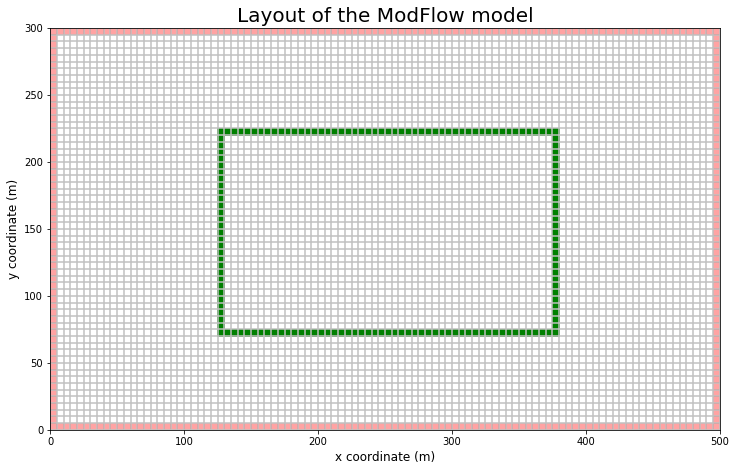

In [5]:
plt.figure(figsize=(12, 12))
plt.axis(aspect='equal')
modelmap = fp.PlotMapView(model=ml)
modelmap.plot_grid(colors='silver')
modelmap.plot_bc('RIV', color='g')
modelmap.plot_bc('GHB', color='r', alpha=0.2)
plt.title('Layout of the ModFlow model', fontsize=20)
plt.xlabel('x coordinate (m)', fontsize= 12)
plt.ylabel('y coordinate (m)', fontsize= 12)

### Model results

The ModFlow model results are imported into the `headfile` variable. The groundwater head in the model area at t=100 days is plotted. 

From the `headfile` a time series are obtained at a location as if there was an observation well present in the system. The observation well is located at cell: `nrow/2 - 1, ncol/2 - 1` or (x, y) = (147.5, 247.5)

In [6]:
# read headfiles
headfile = flopy.utils.binaryfile.HeadFile(modelname + '.hds')
times = headfile.get_times()

h100 = headfile.get_data(totim=times[99])

ts = headfile.get_ts((0, nrow/2 - 1, ncol/2 - 1))

Text(0,0.5,'y coordinate (m)')

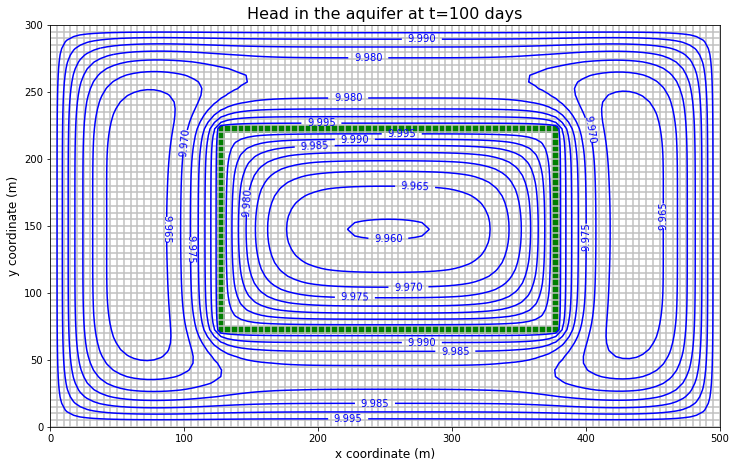

In [7]:
# create contour plot
plt.figure(figsize=(12, 12))
plt.axis(aspect='equal')
modelmap = fp.PlotMapView(model=ml)
modelmap.plot_grid(colors='silver')
modelmap.plot_bc('RIV', color='g')

cs = modelmap.contour_array(h100[0], levels=np.arange(9,11, 0.005), colors='b')
plt.clabel(cs, fmt='%1.3f');
plt.title('Head in the aquifer at t=100 days', fontsize=16)
plt.xlabel('x coordinate (m)', fontsize=12)
plt.ylabel('y coordinate (m)', fontsize=12)

The time series obtained from the ModFlow model is plotted below. 

Text(0,0.5,'Head (m)')

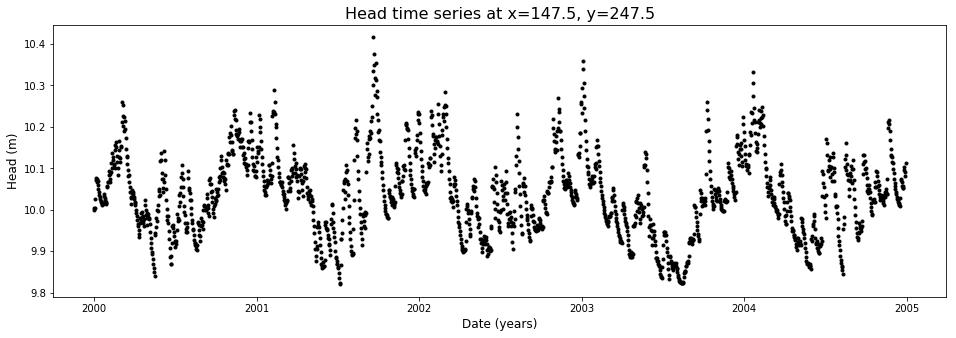

In [8]:
x_val = [x[0] for x in ts]
y_val = [x[1] for x in ts]
date_series = pd.DatetimeIndex(start = recharge.index[0], freq='D', periods=nper)
ho = pd.Series(data=y_val,index=date_series)
plt.figure(figsize=(16,5))
plt.plot(ho, 'k.')
plt.title('Head time series at x=' + str((nrow / 2 - 1) * delr + delr / 2) + 
          ', y=' + str((ncol / 2 - 1) * delc + delc / 2), fontsize=16)
plt.xlabel('Date (years)', fontsize=12)
plt.ylabel('Head (m)', fontsize=12)

### Create Pastas model

A Pastas model is created using the groundwater time series obtained from the ModFlow model as input. A stress model is created using the recharge data series and the Gamma response function as input. The stress model is added to the Pastas model and the model is solved. The results of the model are plotted together with a fit report. 

The results of the Pastas simulation show that the Pastas model is able to simulate the groundwater head in the ModFlow model.

INFO: Inferred frequency from time series None: freq=D 
INFO: Inferred frequency from time series None: freq=D 

Model Results Observations                Fit Statistics
============================    ============================
nfev     39                     EVP                    99.88
nobs     1825                   NSE                     1.00
noise    1                      Pearson R2              1.00
tmin     2000-01-01 00:00:00    RMSE                    0.00
tmax     2004-12-29 00:00:00    AIC                    24.08
freq     D                      BIC                    51.63
warmup   0                      __                          
solver   LeastSquares           ___                         

Parameters (5 were optimized)
               optimal   stderr     initial vary
recharge_A   49.302327   ±0.28%  193.323120    1
recharge_n    1.065240   ±0.06%    1.000000    1
recharge_a    7.995298   ±0.36%   10.000000    1
constant_d    9.998501   ±0.01%   10.037542    1
noise

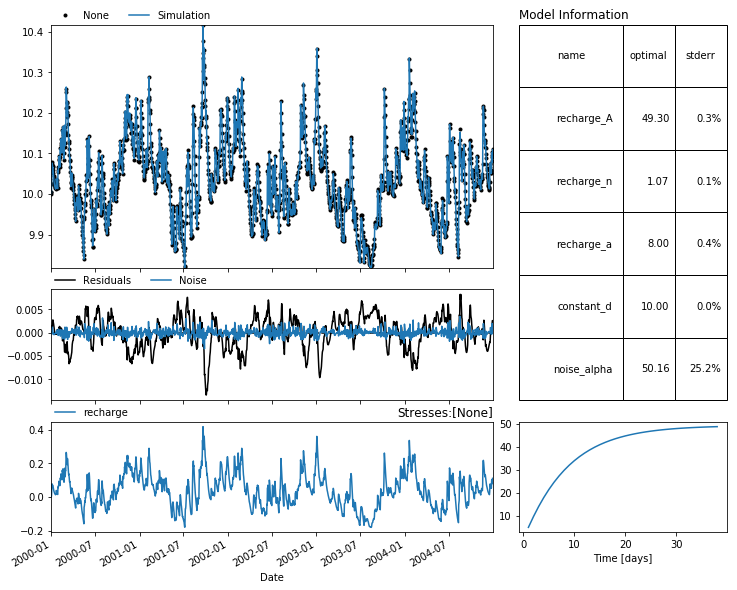

In [9]:
pastas = ps.Model(ho)
sm = ps.StressModel(recharge, settings='prec', rfunc=ps.Gamma, name='recharge')
pastas.add_stressmodel(sm)
pastas.solve(warmup=False)

pastas.plots.results()

### Creating Modflow step response

The step response of the ModFlow model can be obtained by running the model with a constant recharge rate of 1 mm/day. The response function of the ModFlow model is compared to the step response determined with the Pastas simulation. 

Both the response functions are plotted.

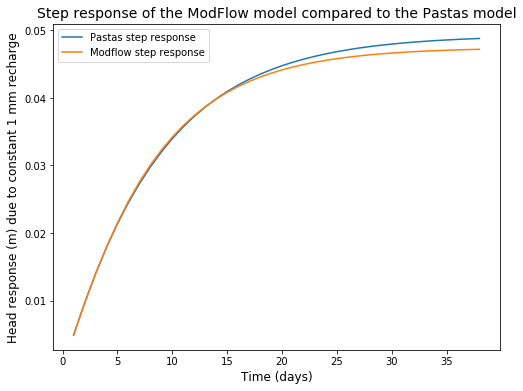

In [10]:
ml_step = mf.Modflow('step_response_model', exe_name='mf2005')
dis = mf.ModflowDis(ml_step, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=botm,
                               nper=nper, perlen=perlen,
                               nstp=nstp, steady=steady)
bas = mf.ModflowBas(ml_step, ibound=ibound, strt=strt)
lpf = mf.ModflowLpf(ml_step, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53)

# add recharge
rch = mf.ModflowRch(ml_step, nrchop=3, rech=0.001)

# add river
riv = mf.ModflowRiv(ml_step, stress_period_data=lrcd)

# output control
oc = mf.ModflowOc(ml_step, stress_period_data=stress_period_data, compact=True)

# add solver
pcg = mf.ModflowPcg(ml_step)

# write modflow files
ml_step.write_input()
ml_step.run_model(silent=True)

# read headfiles and obtain step function
headfile_step = flopy.utils.binaryfile.HeadFile('step_response_model' + '.hds')

ts_step = headfile_step.get_ts((0, nrow/2 - 1, ncol/2 - 1))

x_val_step = [x[0] for x in ts_step]
y_val_step = [x[1] for x in ts_step]

step_pastas = pastas.get_step_response('recharge') / 1000

plt.figure(figsize=(8,6))
plt.plot(step_pastas, label='Pastas step response')
plt.plot(np.array(x_val_step[:len(step_pastas)]),np.array(y_val_step[:len(step_pastas)]) - 10,
         label='Modflow step response')
plt.legend(loc=0)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Head response (m) due to constant 1 mm recharge', fontsize=12)
plt.title('Step response of the ModFlow model compared to the Pastas model', fontsize=14);

### Multi layer model

The first example showed a ModFlow model with a single layer aquifer. This example shows a model with multiple layers with different hydraulic conductivities. The rest of the ModFlow model is the same as in the previous example.

In this example the observation well is located at the same location in the bottom layer.

In [11]:
Lx = 500.
Ly = 300.
ztop = 50
zbot = 0
nlay = 5
nrow = int(Ly/5)
ncol = int(Lx/5)
delr = Lx / ncol
delc = Ly / nrow
delv = (ztop - zbot) / nlay
botm = [8, 6, 4, 2, 0]
hk = [10., 5., 0.001, 10, 5]
vka = [i / 10 for i in hk]
ss = 2e-4
laytyp = -1

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

strt = 10. * np.ones((nlay, nrow, ncol), dtype=np.float32)

# Time step parameters
nper = 5*365
perlen = [1]* nper
nstp = [1] * nper
steady = [False] * nper

# create model
ml = mf.Modflow('example_model_2', exe_name='mf2005')
dis = mf.ModflowDis(ml, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=botm,
                               nper=nper, perlen=perlen,
                               nstp=nstp, steady=steady)
bas = mf.ModflowBas(ml, ibound=ibound, strt=strt)
lpf = mf.ModflowLpf(ml, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53)

# add general head boundary
stage = 10.
bound = []

cond = hk[0] * (stage - zbot) * delc

for ir in range(nrow):
    bound.append([0, ir, 0, stage, cond])
    bound.append([0, ir, ncol - 1, stage, cond])
for ic in range(1,ncol-1):
    bound.append([0, 0, ic, stage, cond])
    bound.append([0, nrow-1, ic, stage, cond])

ghb = mf.ModflowGhb(ml, stress_period_data={0: bound})

# add river
hriv=10
c= 0.001
lrcd = []
rbot = botm[0]
for i in range(int(nrow/4),int(3/4*nrow)+1):
    lrcd.append([0, i, int(ncol/4), hriv, (delc*delr)/c, rbot])
    lrcd.append([0, i, int(ncol*3/4), hriv, (delc*delr)/c, rbot])

for i in range(int(ncol/4),int(3/4*ncol)+1):
    lrcd.append([0, int(nrow/4), i, hriv,  (delc*delr)/c, rbot])
    lrcd.append([0, int(nrow*3/4), i, hriv,  (delc*delr)/c, rbot])

riv = mf.ModflowRiv(ml, stress_period_data=lrcd)

# add recharge
rech = {}
for i in range(nper):
    rech[i] = recharge.iloc[i]
rch = mf.ModflowRch(ml, nrchop=3, rech=rech)

# output control
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ['save head',
                                            'save budget',
                                            'print head',
                                            'print budget']
oc = mf.ModflowOc(ml, stress_period_data=stress_period_data,
                             compact=True)

# add solver
pcg = mf.ModflowPcg(ml)

# write modflow files
ml.write_input()
ml.run_model(silent=True);

The results of the model are imported into the variable `headfile`. The groundwater time series at the location of the observation well is plotted.  

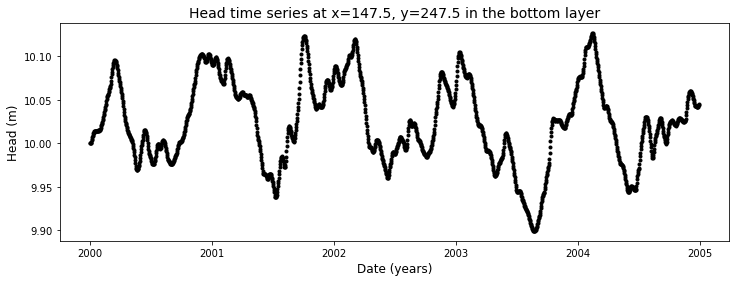

In [12]:
# read headfiles
headfile = flopy.utils.binaryfile.HeadFile('example_model_2' + '.hds')

ts = headfile.get_ts([(4, nrow/2 - 1, ncol/2 - 1)])

x_val = [x[0] for x in ts]
y_val = [x[1] for x in ts]
date_series = pd.DatetimeIndex(start = recharge.index[0], freq='D', periods=nper)
ho = pd.Series(data=y_val,index=date_series)
plt.figure(figsize=(12,4))
plt.plot(ho, 'k.')
plt.title('Head time series at x=' + str((nrow / 2 - 1) * delr + delr / 2) + 
          ', y=' + str((ncol / 2 - 1) * delc + delc / 2)+ ' in the bottom layer', fontsize=14)
plt.xlabel('Date (years)', fontsize=12)
plt.ylabel('Head (m)', fontsize=12);

### Create Pastas model for the multi layer model

A Pastas model is created with the groundwater time series of the multi layer model as input. A stress model is created and added to the model. The fit report and the results of the Pastas model are plotted.

INFO: Inferred frequency from time series None: freq=D 
INFO: Inferred frequency from time series None: freq=D 

Model Results Observations                Fit Statistics
============================    ============================
nfev     42                     EVP                    99.64
nobs     1825                   NSE                     1.00
noise    1                      Pearson R2              1.00
tmin     2000-01-01 00:00:00    RMSE                    0.00
tmax     2004-12-29 00:00:00    AIC                    29.63
freq     D                      BIC                    57.18
warmup   1                      __                          
solver   LeastSquares           ___                         

Parameters (5 were optimized)
               optimal   stderr     initial vary
recharge_A   30.481879   ±0.31%  193.323120    1
recharge_n    2.145102   ±0.16%    1.000000    1
recharge_a   12.742283   ±0.33%   10.000000    1
constant_d   10.000897   ±0.00%   10.024499    1
noise

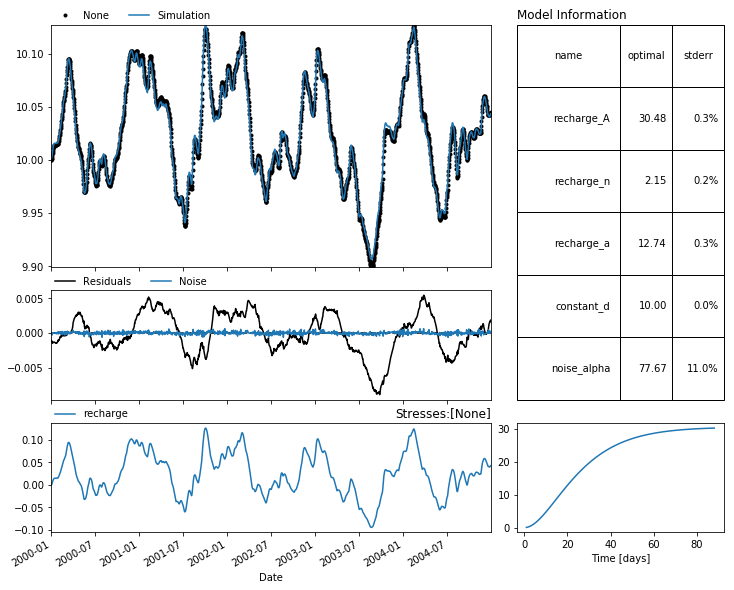

In [13]:
pastas = ps.Model(ho)
sm = ps.StressModel(recharge, settings='prec', rfunc=ps.Gamma, name='recharge')
pastas.add_stressmodel(sm)
pastas.solve(warmup=True)

pastas.plots.results()